In [2]:
import pandas
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
random.seed(1)

In [3]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np

In [7]:
dataset_path = "/content/IMDB Dataset.csv"
dataset_df = pandas.read_csv(dataset_path)

In [8]:
dataset_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\bbr\b', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\"'`]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and token not in string.punctuation
    ]
    return ' '.join(cleaned)

dataset_df['cleaned_reviews'] = dataset_df['review'].apply(clean_text)
print(dataset_df['cleaned_reviews'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


0    one reviewer mentioned watching oz episode you...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: cleaned_reviews, dtype: object


In [10]:
dataset_df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [11]:
le = LabelEncoder()
dataset_df['sentiment_encoded'] = le.fit_transform(dataset_df['sentiment'])

In [12]:
X = dataset_df['cleaned_reviews']
y = dataset_df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [14]:
model_lstm = Sequential([
    Input(shape=(100,)),
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dense(1, activation="sigmoid")
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [16]:
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [23]:
history = model_lstm.fit(X_train_pad, y_train, validation_split=0.15, epochs=1000, callbacks=[early_stopping, lr_scheduler])

Epoch 1/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9078 - loss: 0.2368 - val_accuracy: 0.8703 - val_loss: 0.3068 - learning_rate: 5.0000e-04
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9324 - loss: 0.1796 - val_accuracy: 0.8652 - val_loss: 0.3381 - learning_rate: 5.0000e-04
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9477 - loss: 0.1417 - val_accuracy: 0.8727 - val_loss: 0.3860 - learning_rate: 5.0000e-04
Epoch 4/1000
1061/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9587 - loss: 0.1149
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9587 - loss: 0.1150 - val_accuracy: 0.8625 - val_loss: 0.4204 - learning_rate: 5.0000e-04
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9756 - loss: 0.0760 - val_accuracy: 0.8647 - val_loss: 0.4963 - learning_rate: 2.5000e-04
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━

In [24]:

# Évaluation complète avec ROC, seuil optimal, matrice de confusion
y_proba = model_lstm.predict(X_test_pad)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Seuil optimal (Youden J)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print("Seuil optimal (Youden J):", optimal_threshold)

# Prédictions binaires avec seuil optimal
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# Matrice de confusion et rapport
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_opt))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_opt))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Seuil optimal (Youden J): 0.5903633
Matrice de confusion :
 [[4343  618]
 [ 597 4442]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



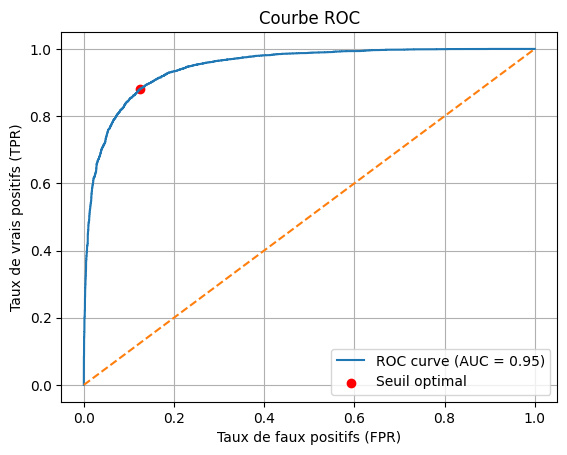

In [25]:

# Courbe ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Seuil optimal')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()


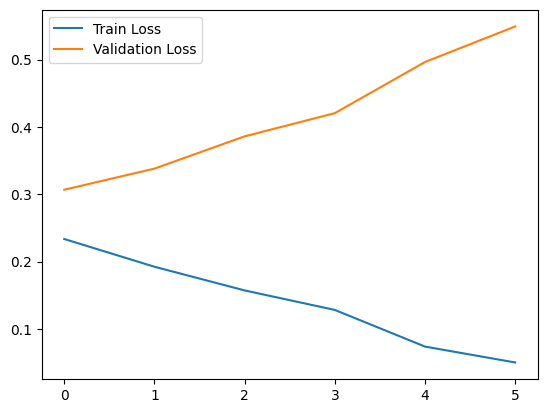

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

In [ ]:
***